Neural Networks


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
   
# Read the CSV file into a pandas DataFrame
data = pd.read_csv('C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_train_sameday_real.csv')
test_data = pd.read_csv('C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_test_sameday_real.csv')
columns_to_remove = ['volume', 'option_price', 'open_interest']
test_data = test_data.drop(columns=columns_to_remove)
data = data.drop(columns=columns_to_remove)
test_data_with_all_predictions = test_data.copy() 

option_columns = [
    'impl_volatility',
    'cp_flag',
    'option_price',
    'stock_price',
    'moneyness',
    'time_to_expiry',
    'strike_price',
    'volume',
    'open_interest',
    'delta',
    'gamma',
    'vega',
    'theta',
    'rf',
    'iv_ahbs',
    'iv_ahbs_error',
    'iv_bs',
    'iv_bs_error',  # Adjusted from a duplicate iv_ahbs_error
    'iv_cw',
    'iv_cw_error'
]

option_only = data #[option_columns]
print(option_only.head())


   impl_volatility  cp_flag  stock_price  moneyness  time_to_expiry  \
0         0.210270        1      115.545   0.970966              24   
1         0.208124        1      115.545   0.962875              24   
2         0.205474        1      115.545   0.954917              24   
3         0.278442        0      115.545   1.100429              24   
4         0.242212        0      115.545   1.050409              24   

   strike_price     delta     gamma       vega      theta  ...  qmj_safety  \
0         119.0  0.329402  0.057909  10.772000 -16.612410  ...    0.820412   
1         120.0  0.273000  0.053728   9.892975 -15.153390  ...    0.820412   
2         121.0  0.220664  0.048533   8.819048 -13.381580  ...    0.820412   
3         105.0 -0.075725  0.017194   4.246497  -9.138635  ...    0.820412   
4         110.0 -0.186759  0.037192   7.995862 -15.079300  ...    0.820412   

   lag_market_value  row_id  position_in_group   iv_ahbs  iv_ahbs_error  \
0     608960.247515     748  

In [2]:
option_only.describe()

,impl_volatility,cp_flag,stock_price,moneyness,time_to_expiry,strike_price,delta,gamma,vega,theta,...,qmj_safety,lag_market_value,row_id,position_in_group,iv_ahbs,iv_ahbs_error,iv_bs,iv_bs_error,iv_cw,iv_cw_error
count,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,...,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06,1.634743e+06
mean,3.537981e-01,5.380307e-01,2.168965e+02,1.020218e+00,7.300222e+01,2.147624e+02,5.380421e-02,3.873576e-02,2.547478e+01,-3.386588e+01,...,3.552225e-01,4.794208e+05,8.929465e+02,2.998319e+00,3.537981e-01,-8.243009e-15,3.537981e-01,1.719827e-16,3.535166e-01,-2.815160e-04
std,1.506111e-01,4.985517e-01,4.090826e+02,1.359392e-01,5.503460e+01,4.113761e+02,3.056761e-01,5.062283e-02,5.177258e+01,7.586591e+01,...,6.458633e-01,6.032378e+05,5.963543e+02,1.632992e+00,6.845167e-02,1.341569e-01,2.775558e-16,1.506111e-01,7.943505e-02,1.288170e-01
min,4.754100e-02,0.000000e+00,4.240000e+00,8.000000e-01,2.000000e+01,3.000000e+00,-9.073340e-01,1.200000e-05,2.025980e-01,-1.690991e+03,...,-1.611451e+00,9.695950e+03,1.000000e+00,1.000000e+00,2.854689e-01,-2.154515e+00,3.537981e-01,-2.477778e+00,2.964836e-01,-2.128016e+00
25%,2.453950e-01,0.000000e+00,5.417500e+01,9.312500e-01,3.100000e+01,5.500000e+01,-2.145145e-01,8.451000e-03,5.968903e+00,-2.856590e+01,...,3.306319e-02,1.253269e+05,4.060000e+02,1.000000e+00,3.213329e-01,-6.560844e-02,3.537981e-01,-7.526790e-02,3.106508e-01,-6.091993e-02
50%,3.201870e-01,1.000000e+00,1.165750e+02,9.919259e-01,5.100000e+01,1.150000e+02,9.252500e-02,2.088100e-02,1.196814e+01,-1.209265e+01,...,4.193709e-01,2.250473e+05,8.130000e+02,3.000000e+00,3.411623e-01,2.822443e-02,3.537981e-01,3.361110e-02,3.237097e-01,2.978287e-02
75%,4.290660e-01,1.000000e+00,2.024950e+02,1.080600e+00,1.000000e+02,2.000000e+02,3.255225e-01,4.950700e-02,2.495603e+01,-5.551389e+00,...,7.976765e-01,5.717957e+05,1.291000e+03,5.000000e+00,3.566926e-01,9.297098e-02,3.537981e-01,1.084031e-01,3.638265e-01,8.982094e-02
max,2.831576e+00,1.000000e+00,3.727041e+03,1.600000e+00,2.400000e+02,4.650000e+03,7.942570e-01,1.498561e+00,1.140035e+03,-2.101790e-01,...,1.684947e+00,3.071345e+06,3.353000e+03,5.000000e+00,9.958554e-01,5.603367e-01,3.537981e-01,3.062571e-01,1.068055e+00,4.319908e-01


In [ ]:
###########################################
# PART 1: NEURAL NETWORK MODEL DEFINITION
###########################################

def create_nn_model(architecture_type, input_dim):

    model = Sequential()
    
    # Define architecture based on specifications
    if architecture_type == 'NN3':
        # Three hidden layers with 32, 16, and 8 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(1))
    
    elif architecture_type == 'NN4':
        # Four hidden layers with 32, 16, 8, and 4 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    else:
        raise ValueError("Invalid architecture type. Choose from 'NN3' or 'NN4'.")
    
    # Compile model with Adam optimizer for faster training
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    
    return model

def train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=100):

    # Early stopping with optimized parameters
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )
    ]
    
    # Train model with larger batch size for better speed
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=0.0,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_scaled, batch_size=128, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    
    return history, mse


In [ ]:
###########################################
# PART 2: DATA PREPARATION
###########################################

def prepare_data(option_only):

    # Prepare features and target variables
    feature_columns = [col for col in option_only.columns if col not in 
                      ['iv_bs_error', 'iv_ahbs', "iv_ahbs_error", "iv_bs", 
                       "iv_cw", "iv_cw_error", "impl_volatility"]]
    
    # Instead of using train_test_split, use your predefined sets
    X_train = option_only[feature_columns]  # Features from your training set
    X_test = test_data[feature_columns]  # Features from your test set

    # Target variables for each error type
    y_bs_train = option_only['iv_bs_error']  
    y_bs_test = test_data['iv_bs_error']  

    y_ahbs_train = option_only['iv_ahbs_error']  
    y_ahbs_test = test_data['iv_ahbs_error'] 

    y_cw_train = option_only['iv_cw_error']  
    y_cw_test = test_data['iv_cw_error'] 
    # Initialize a StandardScaler to normalize the features
    scaler = StandardScaler()
    
    # Fit the scaler on the training data and transform both training and testing data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create dictionaries to store multiple target variables
    y_train_dict = {
        'bs': y_bs_train,
        'ahbs': y_ahbs_train,
        'cw': y_cw_train
    }
    
    y_test_dict = {
        'bs': y_bs_test,
        'ahbs': y_ahbs_test,
        'cw': y_cw_test
    }

    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(feature_columns, 'feature_columns.pkl')
    
    return X_train_scaled, X_test_scaled, y_train_dict, y_test_dict, scaler, feature_columns

In [ ]:
def predict_and_add_to_test_data(models, test_data, feature_columns, scaler, error_type):

    # Create a copy of the test data to avoid modifying the original
    result_df = test_data
   
    # Extract features from test data as DataFrame (not as numpy array)
    X_test = test_data[feature_columns]
   
    # Scale the features using the pre-fitted scaler and convert back to DataFrame
    # This preserves feature names and prevents the warning
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_columns,
        index=X_test.index
    )
   
    # Original value column name
    original_column = f'iv_{error_type}'
   
    # Generate predictions for each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test_scaled, batch_size=128, verbose=0)
       
        # Flatten predictions if needed
        if len(predictions.shape) > 1:
            predictions = predictions.flatten()
       
        # Add predictions to the dataframe
        column_name = f'iv_{error_type}_pred_{model_name}'
        result_df[column_name] = predictions
       
        # Calculate corrected value by adding the error prediction to the original value
        result_df[f'iv_{error_type}_corrected_{model_name}'] = result_df[original_column] - predictions
   
    return result_df

In [ ]:

###########################################
# PART 4: COMPLETE WORKFLOW
###########################################

if __name__ == "__main__":

    # Step 2: Prepare data
    X_train_scaled, X_test_scaled, y_train_dict, y_test_dict, scaler, feature_columns = prepare_data(option_only)
    
    # Step 3: Train models for each target variable
    models = {}
    results = {}
    
    # Dictionary to store all models
    all_models = {
        'bs': {},
        'ahbs': {},
        'cw': {}
    }
    
    # Train models for each error type
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"/n=== Training models for {error_type} error correction ===")
        
        # Get the appropriate training and test targets
        y_train = y_train_dict[error_type]
        y_test = y_test_dict[error_type]
        
        # Train each architecture
        for nn_type in ['NN3', 'NN4']:
            model_name = f"{nn_type}_{error_type}"
            print(f"/nTraining {model_name}...")
            
            # Create model
            model = create_nn_model(nn_type, X_train_scaled.shape[1])
            
            # Train and evaluate model
            history, mse = train_and_evaluate_model(
                model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=50
            )
            
            # Store model and results
            all_models[error_type][nn_type] = model
            results[model_name] = {
                'mse': mse,
                'history': history
            }
            
            print(f"{model_name} Test MSE: {mse}")
            
            # Save model
            save_model(model, f"{model_name}_model_sameday.h5")
    
    # Step 4: Generate predictions on new test data for each error type
for error_type in ['bs', 'ahbs', 'cw']:
    print(f"\n=== Making predictions for {error_type} error correction ===")
    
    # Extract the models for this error type
    current_models = all_models[error_type]
    
    # Make predictions - use the accumulated DataFrame
    test_data_with_all_predictions = predict_and_add_to_test_data(
        current_models, test_data_with_all_predictions,feature_columns,  scaler, error_type
    )
    
    # Save intermediate results if desired
    test_data_with_all_predictions.to_csv(f'test_data_with_{error_type}_predictions_sameday.csv', index=False)
    
    # Display sample results from accumulated DataFrame
    print(f"\nSample of test data with {error_type} predictions:")
    display_columns = ['iv_' + error_type]
    for nn_type in ['NN3', 'NN4']:
        display_columns.extend([
            f'iv_{error_type}_pred_{nn_type}', 
            f'iv_{error_type}_corrected_{nn_type}'
        ])
    
    print(test_data_with_all_predictions[display_columns].head(5))
    save_model(model, f"{model_name}_model_sameday.h5")



/n=== Training models for bs error correction ===
/nTraining NN3_bs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 739us/step - loss: 0.0044 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 736us/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 720us/step - loss: 0.0012 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 728us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 692us/step - loss: 9.2686e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 698us/step - loss: 9.1838e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 727us/step - loss: 9.2609e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 703us/step - loss: 8.6539e-04 - learning_rate: 0.0100
Epoch 9/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 691us/step - loss: 8.5293e-04 - learning_rate: 0.0100
Epoch 10/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 730us/step - loss: 8.6092e-04 - learning_rate: 0.0100
Epoc

NN3_bs Test MSE: 0.00021355197680006155
/nTraining NN4_bs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 762us/step - loss: 0.0031 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 736us/step - loss: 0.0014 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 736us/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 732us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 728us/step - loss: 9.5393e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 748us/step - loss: 9.3384e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 738us/step - loss: 9.0412e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 732us/step - loss: 8.9415e-04 - learning_rate: 0.0100
Epoch 9/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 728us/step - loss: 8.8683e-04 - learning_rate: 0.0100
Epoch 10/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 732us/step - loss: 8.6549e-04 - learning_rate: 0.0100
Epo

NN4_bs Test MSE: 0.0001971696573088842
/n=== Training models for ahbs error correction ===
/nTraining NN3_ahbs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 706us/step - loss: 0.0046 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 710us/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 709us/step - loss: 9.8424e-04 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 705us/step - loss: 8.8724e-04 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 710us/step - loss: 8.3545e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 709us/step - loss: 8.0123e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 711us/step - loss: 7.7626e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 707us/step - loss: 7.7088e-04 - learning_rate: 0.0100
Epoch 9/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 710us/step - loss: 7.4322e-04 - learning_rate: 0.0100
Epoch 10/50
12748/12772 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 7.5350e-04
Epoch 10: ReduceLROnP

NN3_ahbs Test MSE: 0.00017646113713420497
/nTraining NN4_ahbs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 738us/step - loss: 0.0032 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 741us/step - loss: 0.0011 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 742us/step - loss: 9.6899e-04 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 739us/step - loss: 8.9555e-04 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 738us/step - loss: 8.4994e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 738us/step - loss: 8.2791e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 737us/step - loss: 7.8783e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 743us/step - loss: 8.1862e-04 - learning_rate: 0.0100
Epoch 9/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 743us/step - loss: 7.9610e-04 - learning_rate: 0.0100
Epoch 10/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 736us/step - loss: 7.7378e-04 - learning_rate: 

NN4_ahbs Test MSE: 0.00016025812069009112
/n=== Training models for cw error correction ===
/nTraining NN3_cw...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 707us/step - loss: 0.0035 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 711us/step - loss: 9.9998e-04 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 711us/step - loss: 8.9334e-04 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 707us/step - loss: 8.2518e-04 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 714us/step - loss: 7.7039e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 698us/step - loss: 7.4591e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 709us/step - loss: 7.3680e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 703us/step - loss: 7.1838e-04 - learning_rate: 0.0100
Epoch 9/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 9s 708us/step - loss: 7.0431e-04 - learning_rate: 0.0100
Epoch 10/50
12767/12772 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 7.3500e-04
Epoch 10: ReduceL

NN3_cw Test MSE: 0.0001827914913350671
/nTraining NN4_cw...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 746us/step - loss: 0.0023 - learning_rate: 0.0100
Epoch 2/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 743us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 3/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 748us/step - loss: 9.2365e-04 - learning_rate: 0.0100
Epoch 4/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 745us/step - loss: 8.5379e-04 - learning_rate: 0.0100
Epoch 5/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 745us/step - loss: 7.8104e-04 - learning_rate: 0.0100
Epoch 6/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 747us/step - loss: 7.7594e-04 - learning_rate: 0.0100
Epoch 7/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 746us/step - loss: 7.5254e-04 - learning_rate: 0.0100
Epoch 8/50
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 751us/step - loss: 7.5745e-04 - learning_rate: 0.0100
Epoch 9/50
12728/12772 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 7.4946e-04
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
12772/12772 ━━━━━━━━━━━━━━━━━━━━ 10s 748

NN4_cw Test MSE: 0.00019410699787397582

=== Making predictions for bs error correction ===



Sample of test data with bs predictions:
      iv_bs  iv_bs_pred_NN3  iv_bs_corrected_NN3  iv_bs_pred_NN4  \
0  0.353798        0.140830             0.212968        0.158107   
1  0.353798        0.143606             0.210192        0.160190   
2  0.353798        0.149910             0.203888        0.163445   
3  0.353798        0.157907             0.195891        0.152480   
4  0.353798        0.119842             0.233956        0.117977   

   iv_bs_corrected_NN4  
0             0.195691  
1             0.193608  
2             0.190353  
3             0.201318  
4             0.235821  

=== Making predictions for ahbs error correction ===



Sample of test data with ahbs predictions:
    iv_ahbs  iv_ahbs_pred_NN3  iv_ahbs_corrected_NN3  iv_ahbs_pred_NN4  \
0  0.350970          0.143968               0.207003          0.143916   
1  0.349422          0.142653               0.206769          0.143722   
2  0.348100          0.142570               0.205530          0.143921   
3  0.344389          0.153456               0.190933          0.139490   
4  0.359680          0.125961               0.233719          0.123416   

   iv_ahbs_corrected_NN4  
0               0.207054  
1               0.205700  
2               0.204180  
3               0.204899  
4               0.236264  

=== Making predictions for cw error correction ===



Sample of test data with cw predictions:
      iv_cw  iv_cw_pred_NN3  iv_cw_corrected_NN3  iv_cw_pred_NN4  \
0  0.316475        0.107001             0.209474        0.103559   
1  0.315673        0.105770             0.209903        0.101755   
2  0.315839        0.107271             0.208568        0.103490   
3  0.341157        0.129170             0.211987        0.138282   
4  0.329592        0.082906             0.246686        0.093440   

   iv_cw_corrected_NN4  
0             0.212916  
1             0.213918  
2             0.212350  
3             0.202874  
4             0.236152  


Calculate IVRMSE

In [ ]:
def load_models(model_paths_dict):

    loaded_models = {}
    
    for error_type in model_paths_dict:
        loaded_models[error_type] = {}
        
        for model_name, path in model_paths_dict[error_type].items():
            try:
                # Handle Windows paths by using raw strings
                path = path.replace('\\', '/')  # Convert backslashes to forward slashes
                
                # Check if file exists
                if not os.path.exists(path):
                    print(f"✗ {error_type} {model_name}: File not found at {path}")
                    loaded_models[error_type][model_name] = None
                    continue
                
                # Load the model
                print(f"Loading {error_type} {model_name}...")
                model = load_model(path)
                
                # Simple check: can we access layers?
                num_layers = len(model.layers)
                print(f"✓ Model loaded successfully with {num_layers} layers")
                
                # Store loaded model
                loaded_models[error_type][model_name] = model
                
            except Exception as e:
                print(f"✗ Failed to load {error_type} {model_name}: {str(e)}")
                loaded_models[error_type][model_name] = None
    
    return loaded_models

# Example usage
if __name__ == "__main__":
    # Model paths dictionary with proper path handling for Windows
    # Use forward slashes or raw strings to avoid Unicode escape errors
    model_paths_dict = {
        'bs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN3_bs_model_sameday.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN4_bs_model_sameday.h5"
        },
        'ahbs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN3_ahbs_model_sameday.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN4_ahbs_model_sameday.h5"
        },
        'cw': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN3_cw_model_sameday.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network SameDay\With characteristics/NN4_cw_model_sameday.h5"
        }
    }
    
    # Load all models
    loaded_models = load_models(model_paths_dict)
    
    # Print summary of loaded models
    print("\n=== Model Loading Summary ===")
    for error_type in loaded_models:
        for model_name in loaded_models[error_type]:
            status = "✓ Loaded" if loaded_models[error_type][model_name] is not None else "✗ Failed"
            print(f"{error_type} {model_name}: {status}")

Loading bs NN3...
✓ Model loaded successfully with 4 layers
Loading bs NN4...
✓ Model loaded successfully with 5 layers
Loading ahbs NN3...
✓ Model loaded successfully with 4 layers
Loading ahbs NN4...
✓ Model loaded successfully with 5 layers
Loading cw NN3...
✓ Model loaded successfully with 4 layers
Loading cw NN4...
✓ Model loaded successfully with 5 layers

=== Model Loading Summary ===
bs NN3: ✓ Loaded
bs NN4: ✓ Loaded
ahbs NN3: ✓ Loaded
ahbs NN4: ✓ Loaded
cw NN3: ✓ Loaded
cw NN4: ✓ Loaded


In [8]:

scaler_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network SameDay\With characteristics\scaler.pkl"
scaler = joblib.load(scaler_path)

base_df = test_data_with_all_predictions

# 2) determine your features once
exclude_cols = [
    'iv_bs_error','iv_ahbs','iv_ahbs_error','iv_bs','iv_cw','iv_cw_error',
    'impl_volatility','moneyness_category','ID','date','new_id',
    'open_interest','option_price','prediction_horizon',
    'test_date','train_date','volume', 'iv_bs_pred_NN3', 'iv_bs_corrected_NN3', 'iv_bs_pred_NN4', 'iv_bs_corrected_NN4', 'iv_ahbs_pred_NN3', 'iv_ahbs_corrected_NN3', 'iv_ahbs_pred_NN4', 'iv_ahbs_corrected_NN4', 'iv_cw_pred_NN3', 'iv_cw_corrected_NN3', 'iv_cw_pred_NN4', 'iv_cw_corrected_NN4'
]
feature_columns = [c for c in base_df.columns if c not in exclude_cols]
print(feature_columns)
# 3) loop over error types _and_ models, but update the SAME DataFrame
df = base_df
for error_type in ['bs','ahbs','cw']:
    print(f"\n-- predicting corrections for {error_type} --")
    
    models_for_type = loaded_models[error_type]  # e.g. [nn3_model, nn4_model]
    
    # assume your helper loops through each model internally,
    # adding both iv_{error_type}_pred_NN3/_NN4 and iv_{error_type}_corrected_NN3/_NN4
    df = predict_and_add_to_test_data(
        models_for_type, df, feature_columns, scaler, error_type
    )
    
    # show a quick peek
    cols = ['impl_volatility', f'iv_{error_type}']
    for m in ['NN3','NN4']:
        cols += [f'iv_{error_type}_pred_{m}', f'iv_{error_type}_corrected_{m}']
    print(df[cols].head(3))


['cp_flag', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'delta', 'gamma', 'vega', 'theta', 'rf', 'me', 'ff49', 'div12m_me', 'chcsho_12m', 'eqnpo_12m', 'ret_1_0', 'ret_3_1', 'ret_6_1', 'ret_9_1', 'ret_12_1', 'ret_12_7', 'ret_60_12', 'seas_1_1an', 'seas_1_1na', 'seas_2_5an', 'seas_2_5na', 'seas_6_10an', 'seas_6_10na', 'seas_11_15an', 'seas_11_15na', 'at_gr1', 'sale_gr1', 'capx_gr1', 'inv_gr1', 'debt_gr3', 'sale_gr3', 'capx_gr3', 'inv_gr1a', 'lti_gr1a', 'sti_gr1a', 'coa_gr1a', 'col_gr1a', 'cowc_gr1a', 'ncoa_gr1a', 'ncol_gr1a', 'nncoa_gr1a', 'fnl_gr1a', 'nfna_gr1a', 'tax_gr1a', 'be_gr1a', 'ebit_sale', 'gp_at', 'cop_at', 'ope_be', 'ni_be', 'ebit_bev', 'netis_at', 'eqnetis_at', 'dbnetis_at', 'oaccruals_at', 'oaccruals_ni', 'taccruals_at', 'taccruals_ni', 'noa_at', 'opex_at', 'at_turnover', 'sale_bev', 'cash_at', 'sale_emp_gr1', 'emp_gr1', 'ni_inc8q', 'noa_gr1a', 'ppeinv_gr1a', 'lnoa_gr1a', 'capx_gr2', 'saleq_gr1', 'niq_be', 'niq_at', 'niq_be_chg1', 'niq_at_chg1', 'dsale_din

In [ ]:
def calculate_ivrmse(predictions_df, error_types=['bs', 'ahbs', 'cw'], models=['NN3', 'NN4']):
    results = {}
    
    # Calculate IVRMSE for each error type and model
    for error_type in error_types:
        orig_col = f'iv_{error_type}'
        
        # Calculate base IVRMSE (before correction)
        base_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[orig_col]))
        results[f"{error_type}_base"] = base_rmse
        
        # Calculate IVRMSE for each model
        for model in models:
            corrected_col = f'iv_{error_type}_corrected_{model}'
            
            # Skip if corrected column doesn't exist
            if corrected_col not in predictions_df.columns:
                print(f"Warning: {corrected_col} column not found, skipping...")
                continue
                
            # Calculate IVRMSE for the corrected predictions
            corrected_diff = predictions_df['impl_volatility'] - predictions_df[corrected_col]
            corrected_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[corrected_col]))
            results[f"{error_type}_{model}"] = corrected_rmse
            
            # Calculate improvement percentage
            improvement = (base_rmse - corrected_rmse) / base_rmse * 100
            results[f"{error_type}_{model}_improvement"] = improvement
    
    return results

# Example usage
if __name__ == "__main__":
    # Assuming test_data_with_all_predictions is your DataFrame with all predictions
    ivrmse_results = calculate_ivrmse(test_data_with_all_predictions)
    
    # Print results in a table format
    print("\n=== IVRMSE Results ===")
    print(f"{'Model':<15} {'IVRMSE':<10} {'Improvement':<12}")
    print("-" * 40)
    
    for error_type in ['bs', 'ahbs', 'cw']:
        base_key = f"{error_type}_base"
        if base_key in ivrmse_results:
            base_rmse = ivrmse_results[base_key]
            print(f"{error_type.upper():<15} {base_rmse:.6f}  {'(baseline)':<12}")
            
            for model in ['NN3', 'NN4']:
                model_key = f"{error_type}_{model}"
                imp_key = f"{error_type}_{model}_improvement"
                
                if model_key in ivrmse_results:
                    print(f"{model_key:<15} {ivrmse_results[model_key]:.6f}  {ivrmse_results[imp_key]:.2f}%")
            print("-" * 40)
    
    # Find best overall model
    model_keys = [k for k in ivrmse_results.keys() if not k.endswith('base') and not k.endswith('improvement')]
    if model_keys:
        best_model = min(model_keys, key=lambda k: ivrmse_results[k])
        print(f"\nBest overall model: {best_model} with IVRMSE = {ivrmse_results[best_model]:.6f}")
        
        base_key = f"{best_model.split('_')[0]}_base"
        imp_key = f"{best_model}_improvement"
        if base_key in ivrmse_results and imp_key in ivrmse_results:
            print(f"Improvement over baseline: {ivrmse_results[imp_key]:.2f}%")


=== IVRMSE Results ===
Model           IVRMSE     Improvement 
----------------------------------------
BS              0.150568  (baseline)  
bs_NN3          0.014613  90.29%
bs_NN4          0.014042  90.67%
----------------------------------------
AHBS            0.134068  (baseline)  
ahbs_NN3        0.013284  90.09%
ahbs_NN4        0.012659  90.56%
----------------------------------------
CW              0.128764  (baseline)  
cw_NN3          0.013520  89.50%
cw_NN4          0.013932  89.18%
----------------------------------------

Best overall model: ahbs_NN4 with IVRMSE = 0.012659
Improvement over baseline: 90.56%


In [ ]:
# Define the moneyness groups
moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['NN3', 'NN4']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):
    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    improvement_df = pd.DataFrame(improvement_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} NN3", f"{et} NN4"])
        improvement_cols.extend([f"{et} NN3", f"{et} NN4"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    improvement_df = improvement_df[[col for col in improvement_cols if col in improvement_df.columns]]
    
    return ivrmse_df, improvement_df

def find_best_models(results):
    best_models = []
    
    for group, group_results in results.items():
        for error_type in ['bs', 'ahbs', 'cw']:
            # Get baseline IVRMSE
            base_key = f"{error_type}_base"
            if base_key not in group_results:
                continue
                
            base_rmse = group_results[base_key]
            
            # Find best model for this error type
            models = [m for m in ['NN3', 'NN4'] if f"{error_type}_{m}" in group_results]
            if not models:
                continue
            
            # Find model with lowest IVRMSE    
            best_model = min(models, key=lambda m: group_results[f"{error_type}_{m}"])
            best_rmse = group_results[f"{error_type}_{best_model}"]
            improvement = group_results[f"{error_type}_{best_model}_improvement"]
            
            # Also get the values for the other model for comparison
            other_models = [m for m in models if m != best_model]
            other_model_data = {}
            if other_models:
                other_model = other_models[0]
                other_rmse = group_results[f"{error_type}_{other_model}"]
                other_improvement = group_results[f"{error_type}_{other_model}_improvement"]
                other_model_data = {
                    f'Other Model': other_model,
                    f'Other IVRMSE': other_rmse,
                    f'Other Improvement %': other_improvement
                }
            
            model_data = {
                'Moneyness Group': group,
                'Error Type': error_type.upper(),
                'Best Model': best_model,
                'Base IVRMSE': base_rmse,
                'Best IVRMSE': best_rmse,
                'Improvement %': improvement
            }
            
            # Add other model data if available
            model_data.update(other_model_data)
            
            best_models.append(model_data)
    
    return pd.DataFrame(best_models)

def print_formatted_tables(results):
 
    # Format results into DataFrames
    ivrmse_df, improvement_df = format_results_table(results)
    
    # Format IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print("IVRMSE by Moneyness Group")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))
    
    # Format improvement table
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))
    
    # Find best models
    best_models_df = find_best_models(results)
    
    # Reset float format for mixed table
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    # Format specific columns
    best_models_df['Base IVRMSE'] = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE'] = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %'] = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    # Count best model occurrences
    model_counts = best_models_df['Best Model'].value_counts()
    print(f"Overall best model distribution: {dict(model_counts)}")
    
    # Average improvement by moneyness group
    print("\nAverage improvement by moneyness group:")
    # Convert percentage strings to numeric values
    best_models_df['Improvement_Numeric'] = pd.to_numeric(best_models_df['Improvement %'].str.rstrip('%'))
    
    # Group and calculate means
    avg_improvement = best_models_df.groupby('Moneyness Group')['Improvement_Numeric'].mean()
    
    # Handle the case where there's only one group (which returns a scalar)
    if isinstance(avg_improvement, pd.Series):
        # Sort if it's a Series with multiple values
        sorted_improvements = avg_improvement.sort_values(ascending=False)
        for group, imp in sorted_improvements.items():
            print(f"  {group}: {imp:.2f}%")
    else:
        # Just print the single value if it's a scalar
        group = best_models_df['Moneyness Group'].iloc[0]
        print(f"  {group}: {avg_improvement:.2f}%")

# Example usage:
results = analyze_ivrmse_by_moneyness(test_data_with_all_predictions)
print_formatted_tables(results)


IVRMSE by Moneyness Group
Moneyness Group  BS Base   BS NN3   BS NN4  AHBS Base  AHBS NN3  AHBS NN4  CW Base   CW NN3   CW NN4
          DOTMC 0.135785 0.016411 0.015849   0.135335  0.015777  0.014512 0.122504 0.016781 0.016753
           OTMC 0.134271 0.012198 0.011730   0.126841  0.011167  0.010554 0.125176 0.011612 0.011756
            ATM 0.140269 0.012736 0.012065   0.135411  0.011430  0.011106 0.131622 0.010955 0.011517
           OTMP 0.131156 0.012656 0.011912   0.129842  0.011189  0.010847 0.128338 0.011183 0.011834
          DOTMP 0.195506 0.018436 0.017904   0.142425  0.016380  0.015787 0.134354 0.016548 0.017296

Improvement Percentage by Moneyness Group
Moneyness Group  BS NN3  BS NN4  AHBS NN3  AHBS NN4  CW NN3  CW NN4
          DOTMC  87.91%  88.33%    88.34%    89.28%  86.30%  86.32%
           OTMC  90.92%  91.26%    91.20%    91.68%  90.72%  90.61%
            ATM  90.92%  91.40%    91.56%    91.80%  91.68%  91.25%
           OTMP  90.35%  90.92%    91.38%    91.65%  

In [11]:
# get the table
dfm, _ = format_results_table(results)


# write to CSV (no index column)
dfm.to_csv('results_nn_s_f.csv', index=False)

Feature Importance

In [ ]:
def analyze_neural_network_weights(model, feature_names, model_name="Neural Network"):

    # Get weights from the first layer
    first_layer_weights = model.layers[0].get_weights()[0]  # Shape: (input_features, neurons)
    
    # Calculate importance as the mean absolute weight for each feature
    importance = np.mean(np.abs(first_layer_weights), axis=1)
    
    # Normalize to sum to 100 for easier interpretation
    importance = 100.0 * (importance / np.sum(importance))
    
    # Create DataFrame with feature names and importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Print the top features
    print(f"Top 20 most important features for {model_name}:")
    print(importance_df.head(20))
    
    return importance_df

def plot_feature_importance(importance_df, model_name="Neural Network", top_n=30):

    # Select top N features
    plot_data = importance_df.head(top_n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 10))
    plt.barh(np.arange(len(plot_data)), plot_data['Importance'], align='center')
    plt.yticks(np.arange(len(plot_data)), plot_data['Feature'])
    plt.xlabel('Relative Importance (%)')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    
    return plt.gcf()  # Return the figure for saving if needed

def calculate_permutation_importance(model, X, y, feature_names, n_repeats=10, random_state=42):

    # Function to predict using the neural network
    def predict_fn(X_data):
        return model.predict(X_data, verbose=0).flatten()
    
    # Calculate permutation importance using the sklearn function
    r = sklearn_permutation_importance(predict_fn, X, y, 
                                      n_repeats=n_repeats,
                                      random_state=random_state)
    
    # Create DataFrame with results
    perm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': r.importances_mean,
        'Std': r.importances_std
    })
    
    # Sort by importance
    perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)
    
    return perm_importance_df

def analyze_deeper_layers(model, layer_indices=None):

    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    layer_info = {}
    
    for i in layer_indices:
        layer = model.layers[i]
        weights = layer.get_weights()
        
        if len(weights) == 0:
            continue
            
        # For each layer, calculate weight statistics
        layer_info[i] = {
            'name': layer.name,
            'type': layer.__class__.__name__,
            'shape': [w.shape for w in weights],
            'weight_stats': {
                'mean': float(np.mean(weights[0])),
                'std': float(np.std(weights[0])),
                'min': float(np.min(weights[0])),
                'max': float(np.max(weights[0])),
                'sparsity': float(np.mean(np.abs(weights[0]) < 1e-10))
            }
        }
        
        if len(weights) > 1:  # Has bias
            layer_info[i]['bias_stats'] = {
                'mean': float(np.mean(weights[1])),
                'std': float(np.std(weights[1])),
                'min': float(np.min(weights[1])),
                'max': float(np.max(weights[1]))
            }
    
    return layer_info

def plot_weight_distributions(model, layer_indices=None):

    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    # Filter to keep only layers with weights
    layers_with_weights = []
    for i in layer_indices:
        if len(model.layers[i].get_weights()) > 0:
            layers_with_weights.append(i)
    
    if not layers_with_weights:
        print("No layers with weights found.")
        return
    
    n_layers = len(layers_with_weights)
    fig, axes = plt.subplots(n_layers, 1, figsize=(10, 3*n_layers))
    
    if n_layers == 1:
        axes = [axes]
    
    for i, layer_idx in enumerate(layers_with_weights):
        layer = model.layers[layer_idx]
        weights = layer.get_weights()[0]
        
        # Flatten weights for histogram
        flat_weights = weights.flatten()
        
        # Plot histogram
        axes[i].hist(flat_weights, bins=50)
        axes[i].set_title(f"Layer {layer_idx}: {layer.name} - Weight Distribution")
        axes[i].set_xlabel("Weight Value")
        axes[i].set_ylabel("Count")
    
    plt.tight_layout()
    return fig

def analyze_activation_patterns(model, X_sample, layer_indices=None):

    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    activation_models = {}
    activation_stats = {}
    
    for i in layer_indices:
        try:
            # Create a model that outputs the activations from this layer
            activation_model = tf.keras.Model(
                inputs=model.input,
                outputs=model.layers[i].output
            )
            
            # Get activations
            activations = activation_model.predict(X_sample, verbose=0)
            
            # Calculate activation statistics
            activation_stats[i] = {
                'layer_name': model.layers[i].name,
                'mean': float(np.mean(activations)),
                'std': float(np.std(activations)),
                'min': float(np.min(activations)),
                'max': float(np.max(activations)),
                'sparsity': float(np.mean(activations < 1e-10)),
                'shape': activations.shape
            }
        except:
            # Skip layers that don't support this analysis
            continue
    
    return activation_stats

# Example usage
if __name__ == "__main__":
    # Get your model - either load from file or use the existing model in memory
    # model = load_model("NN3_bs_model.h5")
    model = all_models['bs']['NN3']  # Adjust this to match your model dictionary structure
    
    # Get feature names
    feature_names = feature_columns
    
    # 1. Analyze weights and show top features
    importance_df = analyze_neural_network_weights(model, feature_names, "NN3 - BS Error Correction")
    
    # 2. Plot feature importance
    fig = plot_feature_importance(importance_df, "NN3 - BS Error Correction", top_n=30)
    plt.savefig("NN3_bs_feature_importance.png")
    plt.close()
    
    # 3. Analyze deeper layers
    layer_info = analyze_deeper_layers(model)
    print("\n=== Layer Information ===")
    for layer_idx, info in layer_info.items():
        print(f"\nLayer {layer_idx}: {info['name']} ({info['type']})")
        print(f"  Shape: {info['shape']}")
        print(f"  Weight stats: Mean={info['weight_stats']['mean']:.4f}, "
              f"Std={info['weight_stats']['std']:.4f}")
        if 'bias_stats' in info:
            print(f"  Bias stats: Mean={info['bias_stats']['mean']:.4f}, "
                  f"Std={info['bias_stats']['std']:.4f}")
    
    # 4. Plot weight distributions
    weight_fig = plot_weight_distributions(model)
    plt.savefig("NN3_bs_weight_distributions.png")
    plt.close()
    
 

Top 20 most important features for NN3 - BS Error Correction:
              Feature  Importance
8               theta    3.127476
4        strike_price    2.237628
1         stock_price    2.120925
6               gamma    1.922714
7                vega    1.559160
3      time_to_expiry    1.379941
9                  rf    1.095630
2           moneyness    1.062253
146    ivol_capm_252d    0.911823
91             pi_nix    0.909498
141     turnover_126d    0.845083
34           debt_gr3    0.798240
96     ocfq_saleq_std    0.786838
150        corr_1260d    0.771222
97        tangibility    0.765769
0             cp_flag    0.756651
29       seas_11_15na    0.739188
147  prc_highprc_252d    0.731740
67            cash_at    0.729633
95              at_be    0.716054

=== Layer Information ===

Layer 0: dense (Dense)
  Shape: [(161, 128), (128,)]
  Weight stats: Mean=0.0765, Std=3.8017
  Bias stats: Mean=-1.6651, Std=10.4357

Layer 1: dense_1 (Dense)
  Shape: [(128, 64), (64,)]
  Weight 

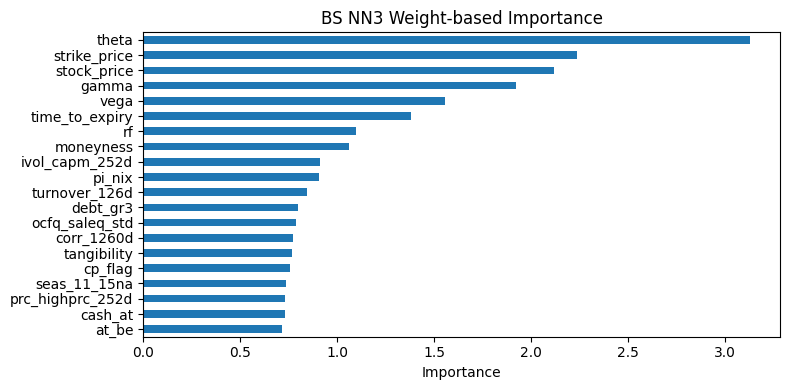

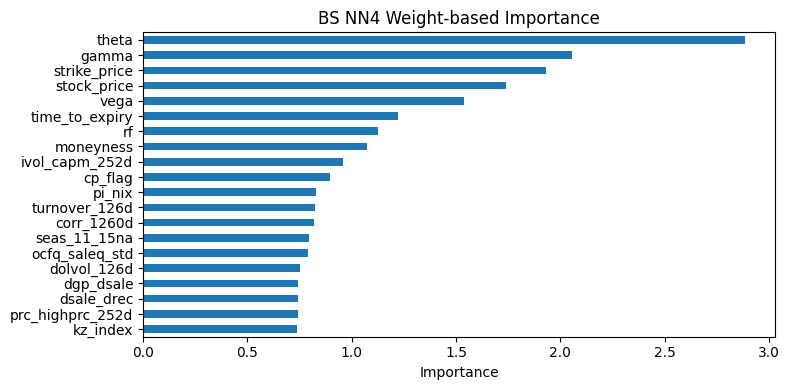

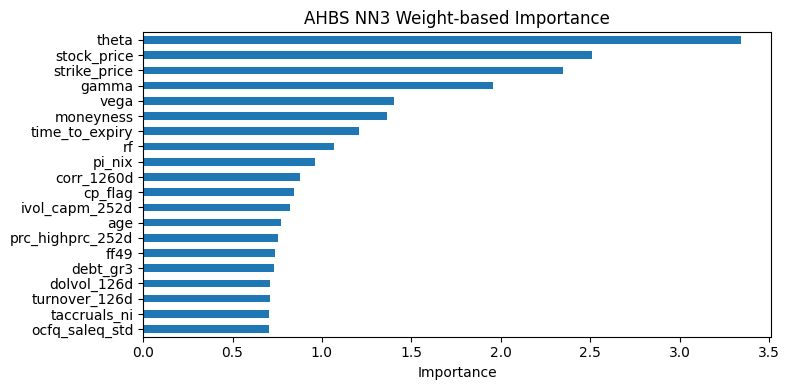

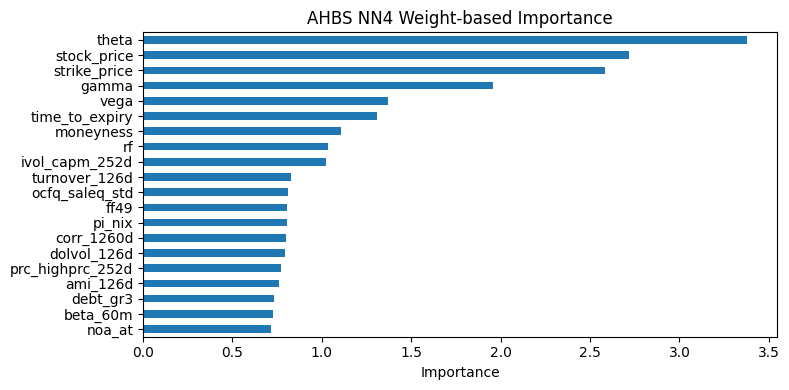

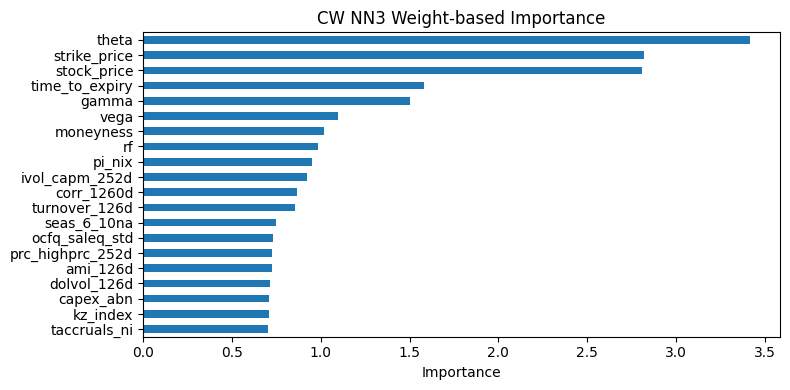

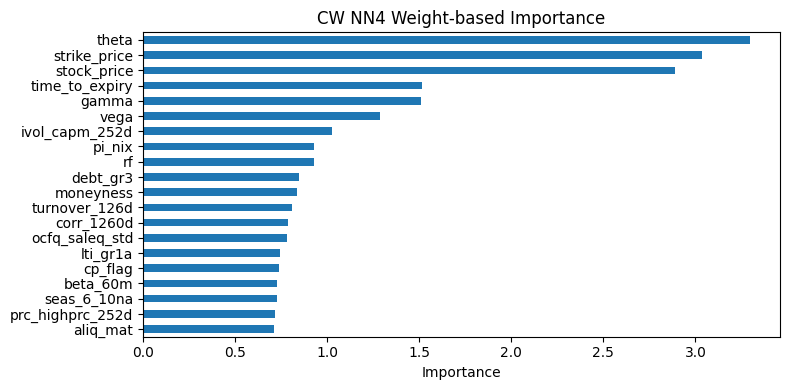

In [ ]:
def weight_importance(model, feature_names: list[str]) -> pd.Series:

    # Extract weights of first layer (input_size x units)
    w = model.layers[0].get_weights()[0]
    imp = np.abs(w).mean(axis=1)
    imp = imp / imp.sum() * 100
    return pd.Series(imp, index=feature_names).sort_values(ascending=False)


def permutation_importance_nn(model, X: np.ndarray, y: np.ndarray,
                              feature_names: list[str],
                              n_repeats: int = 10,
                              random_state: int = 42) -> pd.Series:

    predict_fn = lambda data: model.predict(data, verbose=0).flatten()
    r = permutation_importance(
        predict_fn, X, y,
        n_repeats=n_repeats,
        random_state=random_state
    )
    return pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)


def plot_importance(importance: pd.Series, top_n: int = 20, title: str = "Feature Importance"):

    data = importance.head(top_n).sort_values()
    plt.figure(figsize=(8, max(4, 0.2 * top_n)))
    data.plot.barh()
    plt.xlabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:

groups = ['bs', 'ahbs', 'cw']
arches = ['NN3', 'NN4']

for grp in groups:
    for arch in arches:
        model = all_models[grp][arch]
        imp_w = weight_importance(model, feature_names)
        title = f"{grp.upper()} {arch} Weight-based Importance"
        plot_importance(imp_w, top_n=20, title=title)

